In [1]:
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
n_cores = multiprocessing.cpu_count()

import sys
import os

sys.path.insert(1, os.path.realpath(os.path.pardir))
sys.path.append("../node2vec2rank/")


import pandas as pd
import numpy as np

In [2]:
## experiment info that will be used for folder names and printing/saving the gene set enrichment analysis (GSEA) results

tissue = 'LUAD'
target = 'mVSf'
network_inf_method = 'WGCNA'
gsea_exp_parent_folder_name = 'WGCNA_LUAD_mVSf_paper'
save_gsea_results_notes = ''

In [3]:
# read the configuration file
from node2vec2rank.dataloader import DataLoader
import json

config = json.load(open('../configs/config_wgcna_LUAD_mf.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

In [4]:
#load the data
dataloader = DataLoader(config)

There are 26000 row nodes and 26000 column nodes in graph 1
There are 26000 row nodes and 26000 column nodes in graph 2


In [5]:
#run n2v2r to get the borda and dedi rankings
from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, nodes=dataloader.interest_nodes)
rankings = model.fit_transform_rank()
DeDi_rankings = model.degree_difference_ranking()
borda_ranking = model.aggregate_transform()

../output/01_02_2024_11_57_30

Running n2v2r with dimensions [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] and distance metrics ['euclidean', 'cosine'] ...
	Multi-layer embedding in 11.45 seconds
n2v2r computed 22 rankings for 1 comparison(s) in 65.58 seconds

Rank aggregation with Borda ...
	Finished aggregation in 9.68 seconds


In [6]:
##get the rankings of the comparison and map the ensemble IDs to symbols. TCGA uses gencode v26

#given that this is a sequential analysis with a pair of graphs, we are interested in the 1st comparison 
comparison = '1'
n2v2r_borda_ranking_pd = borda_ranking[comparison].copy()
absDeDi_ranking_pd = DeDi_rankings[comparison][['absDeDi']].copy()

gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}
genes_mapped = [ens2symbol[x] if x in ens2symbol else x for x in dataloader.interest_nodes ]

n2v2r_borda_ranking_pd.index = genes_mapped
absDeDi_ranking_pd.index = genes_mapped


In [7]:
# remove Y chromosome genes genes for the analysis
chrY_gene_names = set(gencode.loc[gencode['seqid'] == 'chrY', 'gene_name'])

absDeDi_ranking_pd = absDeDi_ranking_pd[~absDeDi_ranking_pd.index.isin(chrY_gene_names)]
n2v2r_borda_ranking_pd = n2v2r_borda_ranking_pd[~n2v2r_borda_ranking_pd.index.isin(
    chrY_gene_names)]

In [ ]:
# run prerank GSEA
from node2vec2rank.post_utils import prerank_gseapy

save_results = True

# the gene set library
kegg_pathway_fn = '../data/gene_set_libraries/human/c2.cp.kegg.v7.5.1.symbols.gmt'

# the parameters for prerank
prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500

n2v2r_borda_pre_KEGG_pd = prerank_gseapy(n2v2r_borda_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
absDeDi_pre_KEGG_pd = prerank_gseapy(absDeDi_ranking_pd, kegg_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_borda_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r_borda" +
                            "_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_pre_KEGG_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                            "_absDeDi"+"_prerank_KEGG_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

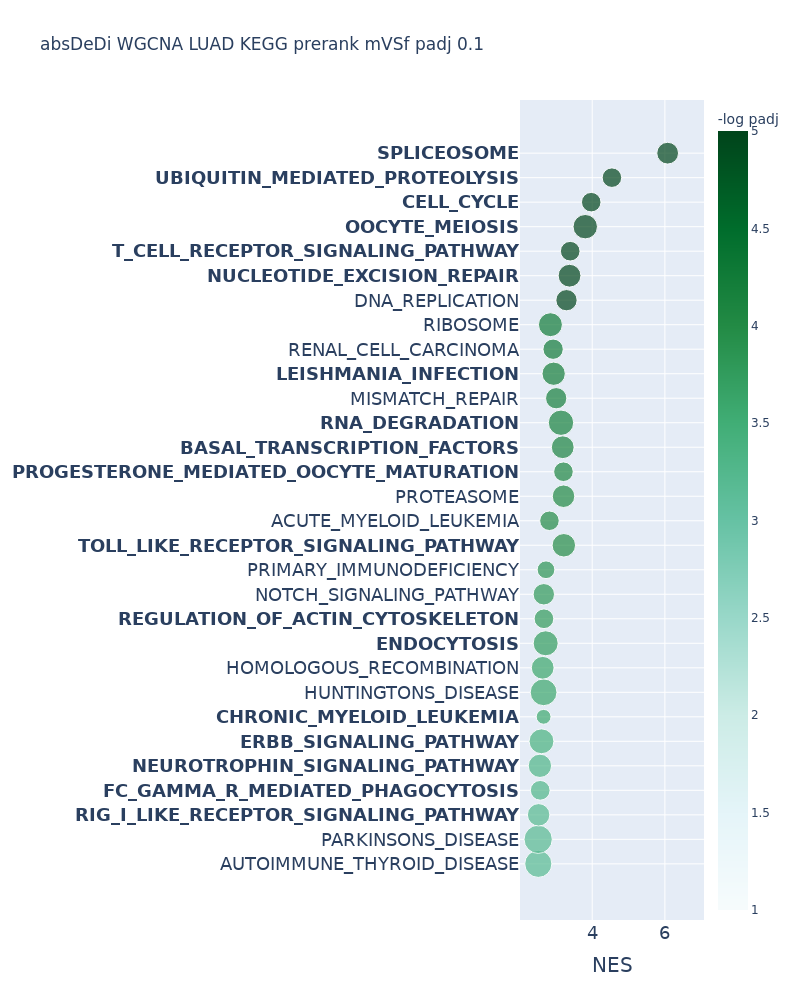

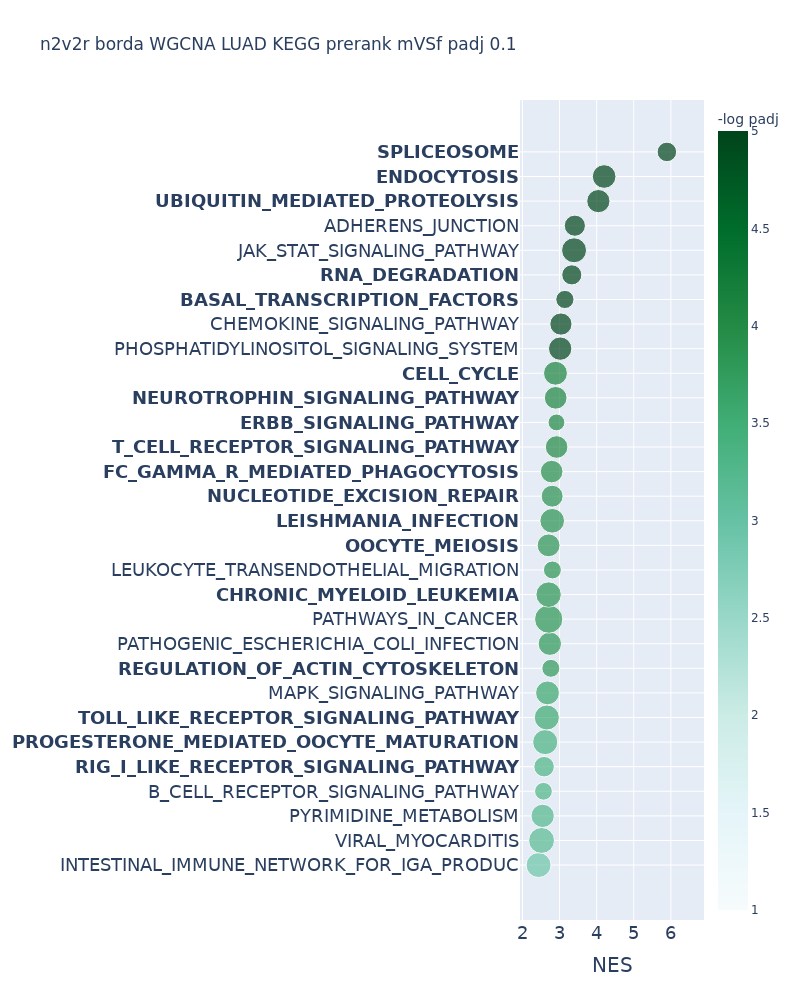

In [9]:
#plot the GSEA results

from node2vec2rank.post_utils import plot_gseapy_prerank 

padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name

#Setting this to True, will allow the notebook figures to be interactive, e.g., hover over points and get more info
#Setting this to False will show the figure as png and non-interactive
#If True, the figures won't be shown when published on github, which is why we set it False here
interactive = False

title = network_inf_method+ " " +  tissue +  " KEGG prerank " + target + " padj " + str(padj_cutoff) 
to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, plot=False)['pathway'].values
to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff, output_dir=save_directory,plot=False)['pathway'].values

plot_gseapy_prerank(absDeDi_pre_KEGG_pd, has_stability=False, characters_trim=40, trim_first_num_characters=5, padj_cutoff=padj_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda, interactive=interactive)
plot_gseapy_prerank(n2v2r_borda_pre_KEGG_pd, has_stability=False, characters_trim=40,trim_first_num_characters=5, padj_cutoff=padj_cutoff,  title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi,interactive=interactive);

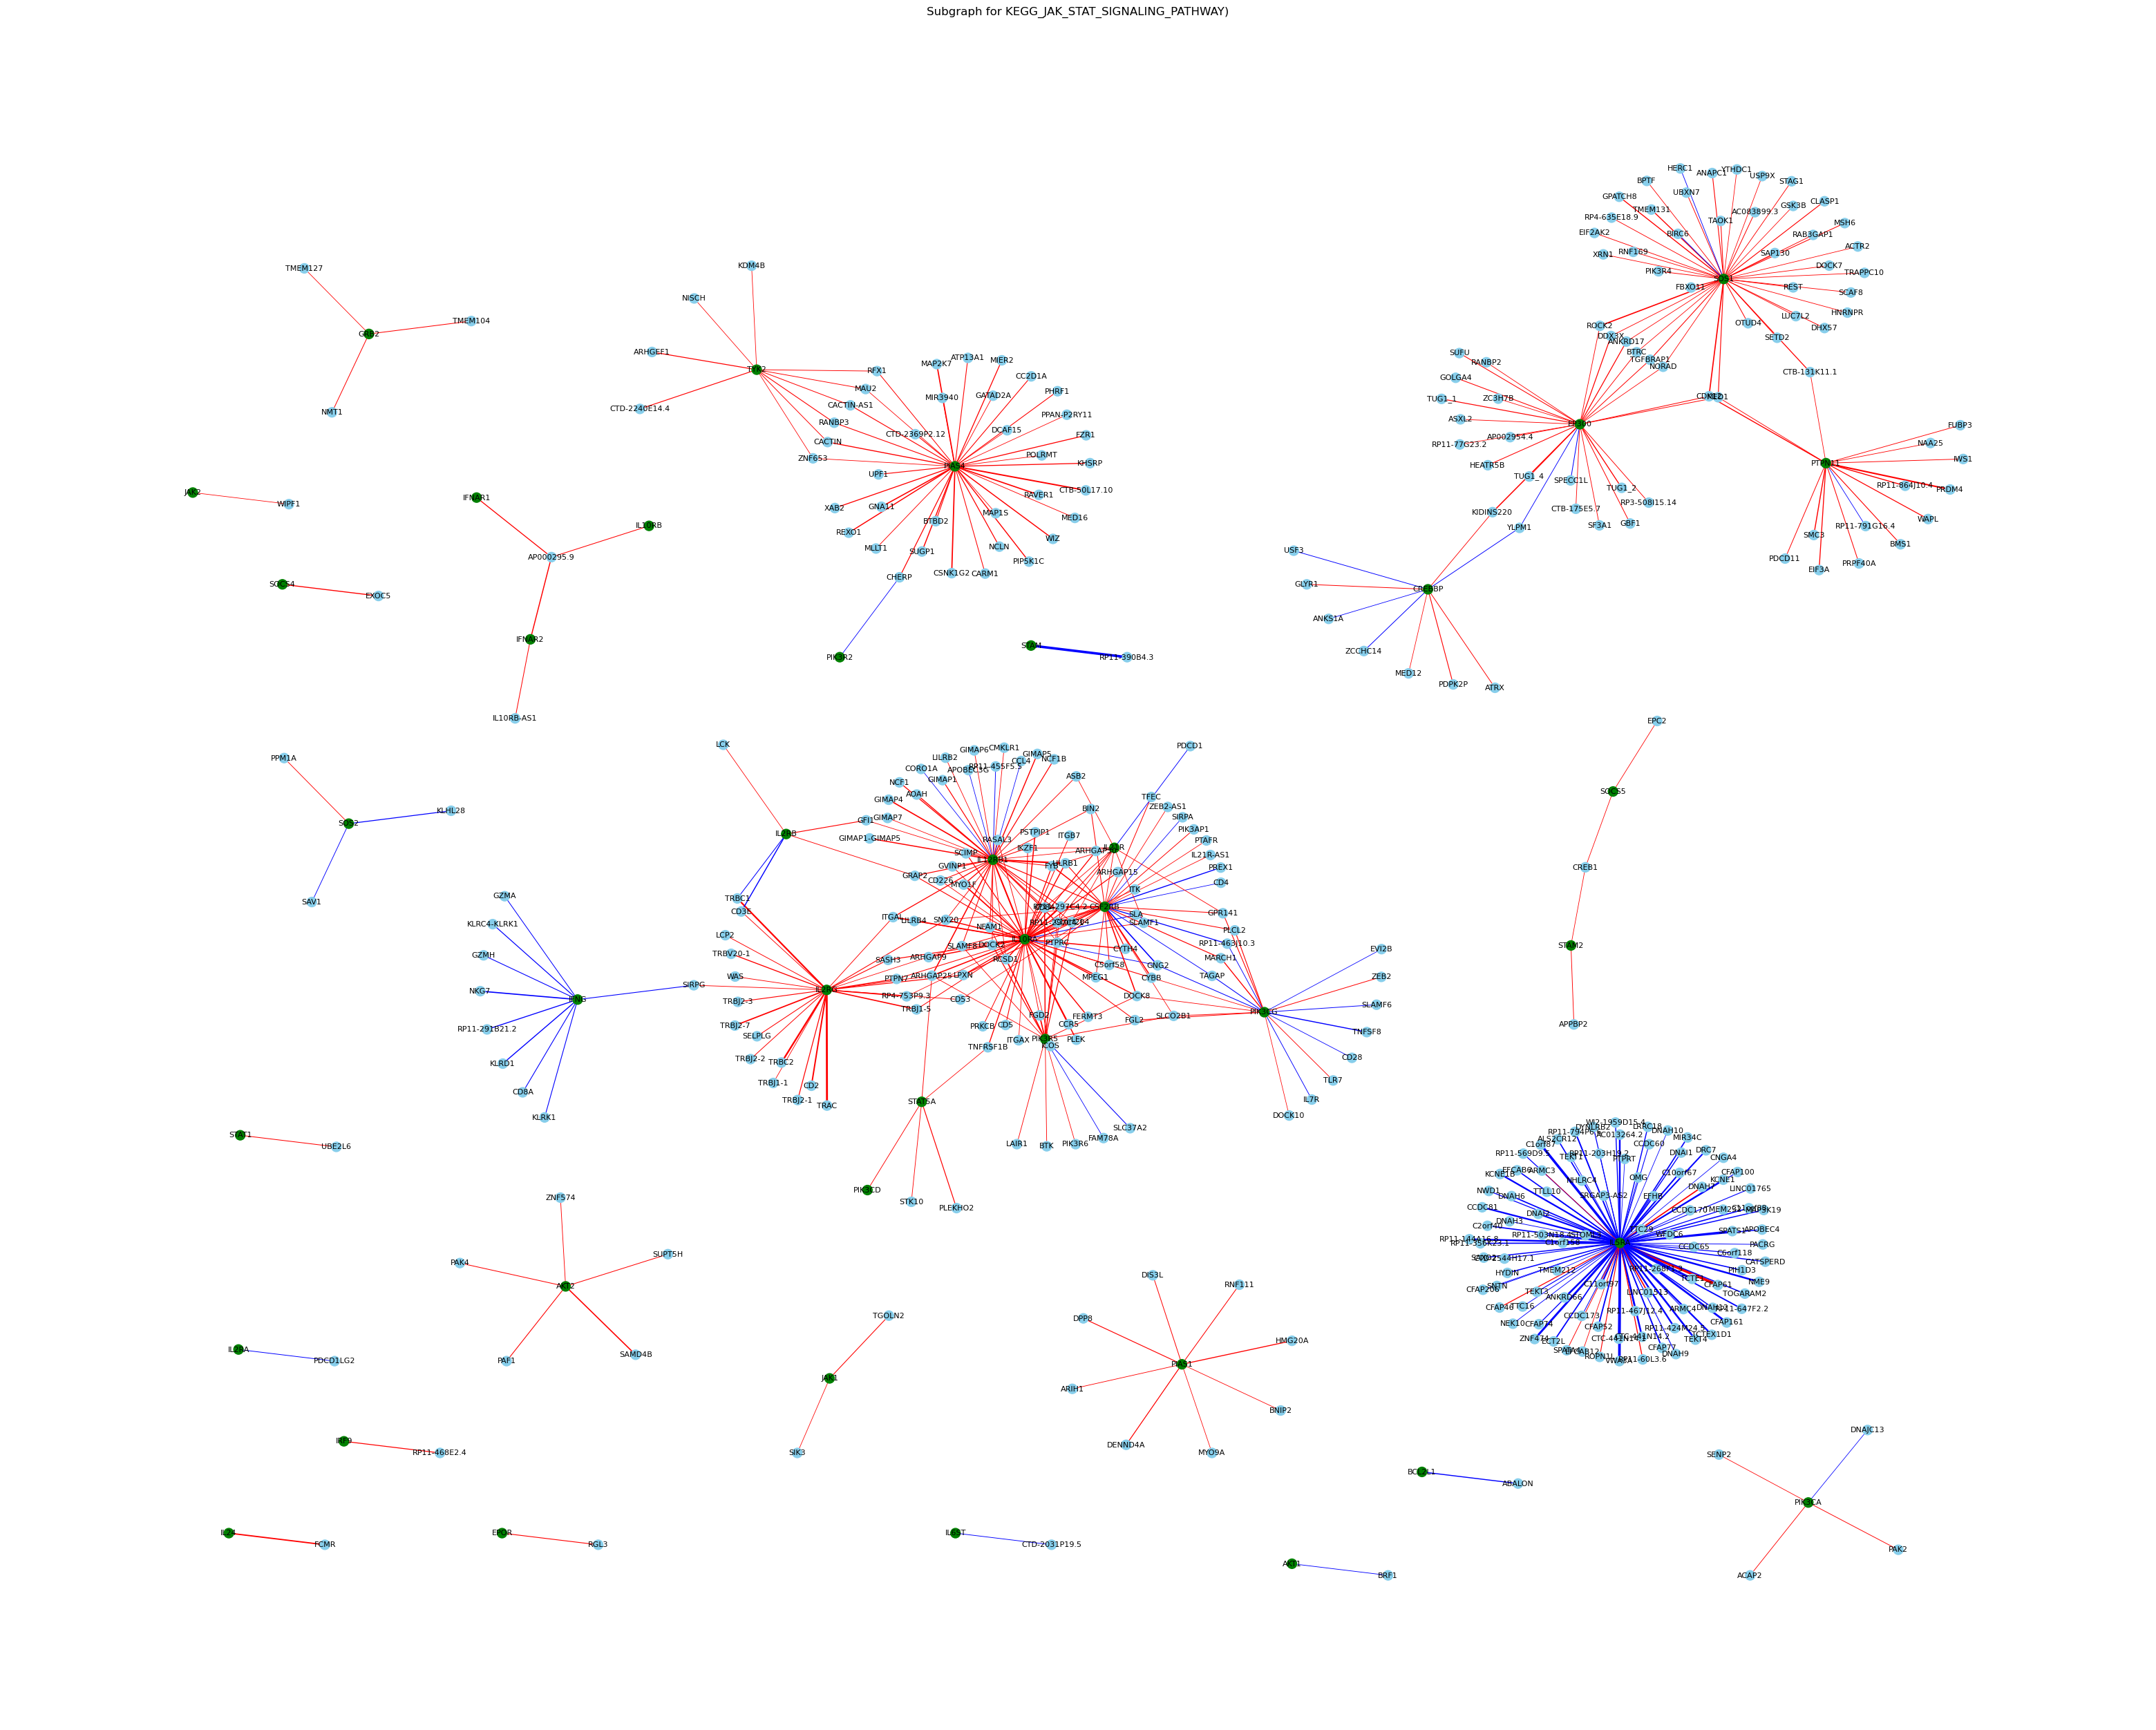

In [20]:
# plot the leading genes of the JAK/STAT pathway


from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

gsea_res_pd = pd.read_csv("../results/results_gsea/"+gsea_exp_parent_folder_name+"/LUAD_WGCNA_mVSf_n2v2r_borda_prerank_KEGG_.tsv", sep='\t')
gsea_res_path_leading_genes = gsea_res_pd.loc[gsea_res_pd['pathway'].isin(['KEGG_JAK_STAT_SIGNALING_PATHWAY']),'Lead_genes']

nodes_to_plot_mapped = []
[nodes_to_plot_mapped.append(x.strip('[]').replace('\'', '').split(', ')) for x in gsea_res_path_leading_genes]
nodes_to_plot_mapped = set(chain(*nodes_to_plot_mapped))


gencode_fn = '../data/gene_set_libraries/human/gen_v26_mapping.csv'
gencode = pd.read_csv(gencode_fn, index_col=0)
ens2symbol = {i['gene_id'].split('.')[0]: i['gene_name']
              for k, i in gencode.iterrows()}


dif_net = dataloader.graphs[1].subtract(dataloader.graphs[0])
dif_net.index = [ens2symbol[x] for x in dif_net.index]
dif_net.columns = [ens2symbol[x] for x in dif_net.columns]
subgraph_pd = dif_net.loc[nodes_to_plot_mapped, :]


# Convert the adjacency matrix to an edge list
edge_list = subgraph_pd.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Source'] != edge_list['Target']]
edge_list['abs_value'] = edge_list['Weight'].abs()
edge_list = edge_list[edge_list['abs_value'] != 0]


# Sort the DataFrame by the absolute values, then keep the top 100
edge_list_top_edges = edge_list.sort_values(by='abs_value', ascending=False).head(500)
G = nx.from_pandas_edgelist(edge_list_top_edges, source='Source', target='Target', edge_attr=True)

fig, ax = plt.subplots(figsize=(40, 32))  # You can adjust the width and height as needed

edge_weights = [10*G[u][v]['abs_value']  for u, v in G.edges]
edge_colors = ['blue' if G[u][v]['Weight'] < 0 else 'red' for u, v in G.edges]

node_colors = ['green' if node in nodes_to_plot_mapped else 'skyblue'  for node in G.nodes]


nx.draw(G, pos=nx.nx_agraph.graphviz_layout(G), with_labels=True, node_size=100, node_color=node_colors, edge_color=edge_colors, width=edge_weights, ax=ax,font_size=8)

plt.title("Subgraph for KEGG_JAK_STAT_SIGNALING_PATHWAY)")
plt.show()